# Course Recommender System

In [33]:
from collections import defaultdict
from itertools import combinations
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from coursemate.dataset import Dataset
from coursemate.metrics import (
    calculate_hit_rate_from_next_course_sequences,
    calculate_precision_from_next_course_sequences,
    calculate_f1score_from_next_course_sequences
)

In [2]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [3]:
%load_ext autoreload
%autoreload 2

## 0. Dataset preparation

In [35]:
dataset = Dataset('data/Coursera_courses.csv', 'data/Coursera.csv', 'data/Coursera_reviews.csv')
dataset.set_interaction_counts(3, 50)
dataset.show_dataset_details()

Loading Coursera courses...
Loading Coursera reviews...
Segmenting out students with less than 3 or more than 50 reviews...
30719 students, 468 courses, 174219 reviews
Sparsity: 1.21%
Duplicates: 4.54%


In [36]:
dataset.set_train_test_split_by_user()

# For the content-based and CF recommender
train_Xmatrix, train_ymatrix, df_train_X, df_train_y = dataset.get_train_matrix_split(ratio=0.8)
test_Xmatrix, test_ymatrix, df_test_X, df_test_y = dataset.get_test_matrix_split(ratio=0.5)

# For the sequential/KB recommender
train_Xseq, test_Xseq, train_yseq, test_yseq = dataset.get_train_test_next_course_predictions()

Setting the train-test split by user...
Computing the training and test rating matrix...


131100it [00:09, 13352.00it/s]


Computing the test rating matrix split...
Computing the training and test rating matrix...


131100it [00:10, 12754.72it/s]
43119it [00:02, 14743.59it/s]


Computing the training and test list of sequences...


131100it [00:07, 16487.77it/s]
43119it [00:02, 16061.25it/s]


In [37]:
print(f"Training: From {len(df_train_X)} ratings, predict the next {len(df_train_y)} for {df_train_y['reviewers'].nunique()} users")
print(f"Testing: From {len(df_test_X)} ratings, predict the next {len(df_test_y)} for {df_test_y['reviewers'].nunique()} users")

Training: From 119949 ratings, predict the next 11151 for 6631 users
Testing: From 157922 ratings, predict the next 16297 for 7680 users


In [38]:
print(f"Training (Sequential): From {len(train_Xseq)} sequences, predict the next course taken for {df_train_y['reviewers'].nunique()} users")
print(f"Testing (Sequential): From {len(test_Xseq)} sequences, predict the next course taken for {df_test_y['reviewers'].nunique()} users")

Training (Sequential): From 108061 sequences, predict the next course taken for 6631 users
Testing (Sequential): From 7680 sequences, predict the next course taken for 7680 users


## 1. EDA


### 1.0 Load datasets and libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

courses_file = 'data/Coursera_courses.csv'
coursedata_file = 'data/Coursera.csv'
ratings_file = 'data/Coursera_reviews.csv'

df_courses = pd.read_csv(courses_file)
df_coursedata = pd.read_csv(coursedata_file)
df_ratings = pd.read_csv(ratings_file)

df_courses.merge(
    df_coursedata,
    left_on='course_url',
    right_on='Course URL',
    how='inner'
).shape

df_coursedata['Course ID'] = df_coursedata['Course URL'].str.split('/').str[-1]


df_courses_full = df_courses.merge(
    df_coursedata.drop_duplicates('Course ID', keep='first'),
    left_on='course_id',
    right_on='Course ID',
    how='inner'
)

df_courses_full = df_courses_full.rename(columns={
    'Difficulty Level': 'difficulty_level',
    'Course Rating': 'rating',
    'Course Description': 'description',
    'Skills': 'skills',
})

df_courses_full = df_courses_full[[
    'course_id', 'name', 'institution', 'difficulty_level', 'rating', 'description', 'skills'
]]

df_courses_full.set_index('course_id', inplace=True)

### 1.1 Most active users

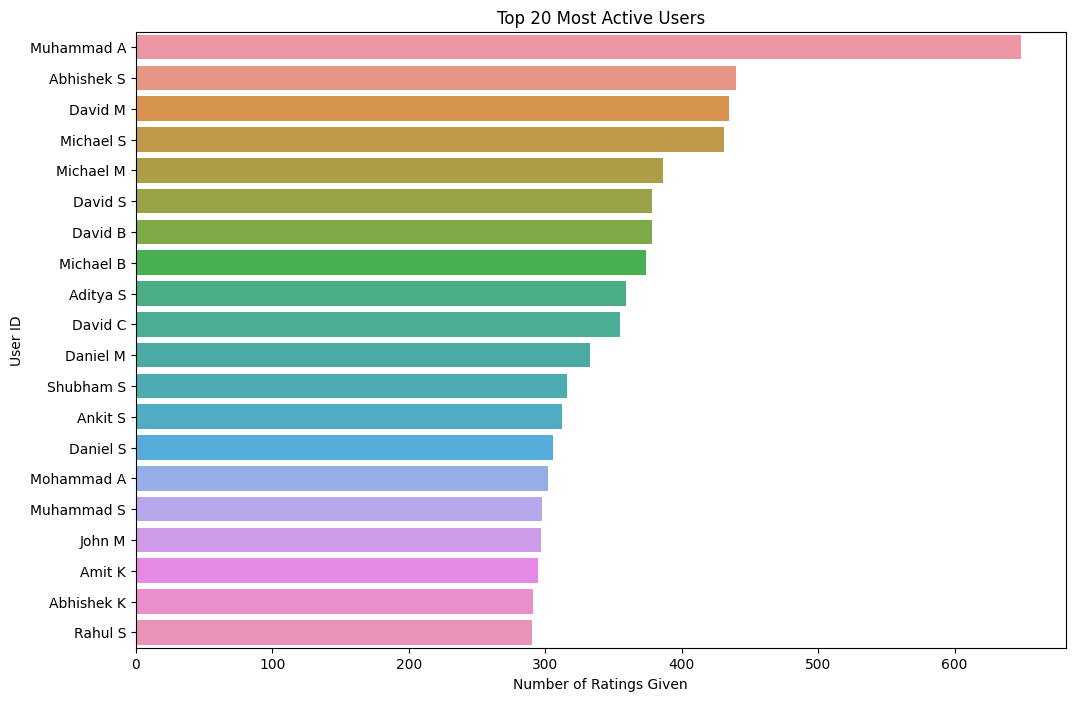

In [26]:
df_ratings_fixed = df_ratings.copy()
# Removing "Deleted A" reviewers
df_ratings_fixed = df_ratings_fixed[df_ratings_fixed['reviewers'] != 'By Deleted A']

# removing "By " from reviewers
df_ratings_fixed['reviewers'] = df_ratings_fixed['reviewers'].str.split(' ').str[1:].str.join(' ')

user_activity = df_ratings_fixed['reviewers'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=user_activity.values, y=user_activity.index)
plt.title('Top 20 Most Active Users')
plt.xlabel('Number of Ratings Given')
plt.ylabel('User ID')
plt.show()

It's unlikely that a single person would complete more than 50 courses, especially not 600.

This high number is likely due to user ID overlaps in the dataset, as we were unable to collect some users’ last name.

To address this, we set a realistic upper bound on the number of courses a user can take.

### 1.2 Upper and lower bounds for number of courses taken per user

Defining function to calculate the sparcity of the dataset when bounded.

In [27]:
df_reviews = df_ratings[df_ratings['course_id'].isin(df_courses_full.index)].drop_duplicates()

df_students = (df_reviews.groupby('reviewers').agg({
    'rating': 'mean',
    'course_id': 'count'
}).rename(columns={'course_id': 'courses', 'rating': 'avg_rating'})
  .sort_values(by='courses', ascending=False))

def sparsity(lb, ub):
    student_set = df_students[df_students['courses'].between(lb, ub)]
    total_students = len(df_students)
    student_count = len(student_set)

    review_set = df_reviews[df_reviews['reviewers'].isin(student_set.index)]
    total_reviews = len(df_reviews)
    review_count = len(review_set)

    total_courses = len(df_courses_full)
    courses_count = df_courses_full.index.isin(review_set['course_id']).sum()

    sparsity = review_count / (student_count * courses_count)
    return (
        review_count / total_reviews,
        courses_count / total_courses,
        student_count / total_students,
        sparsity
    )

**Upper bound**

Text(0.5, 1.0, 'Sparsity of interaction matrix')

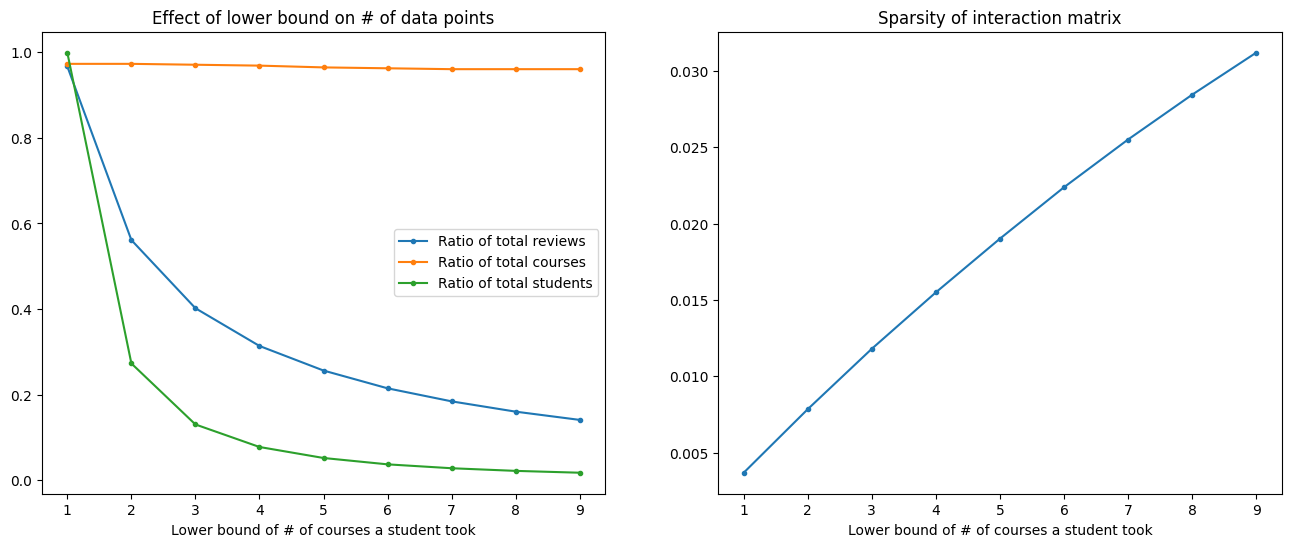

In [28]:
x = np.array([1,2,3, 4, 5, 6, 7, 8, 9])
results = np.array([sparsity(i, 36) for i in x])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(x, results[:, 0], label='Ratio of total reviews', marker='.')
axs[0].plot(x, results[:, 1], label='Ratio of total courses', marker='.')
axs[0].plot(x, results[:, 2], label='Ratio of total students', marker='.')
axs[0].legend()
axs[0].set_xlabel('Lower bound of # of courses a student took')
axs[0].set_title('Effect of lower bound on # of data points')

axs[1].plot(x, results[:, 3], label='Sparsity', marker='.')
axs[1].set_xlabel('Lower bound of # of courses a student took')
axs[1].set_title('Sparsity of interaction matrix')

This was used to determine the effect of an upper bound.

Sparsity was not greatly affected, but it will greatly reduce the effect of these duplicate reviews.

**Lower bound**

Text(0.5, 1.0, 'Sparsity of interaction matrix')

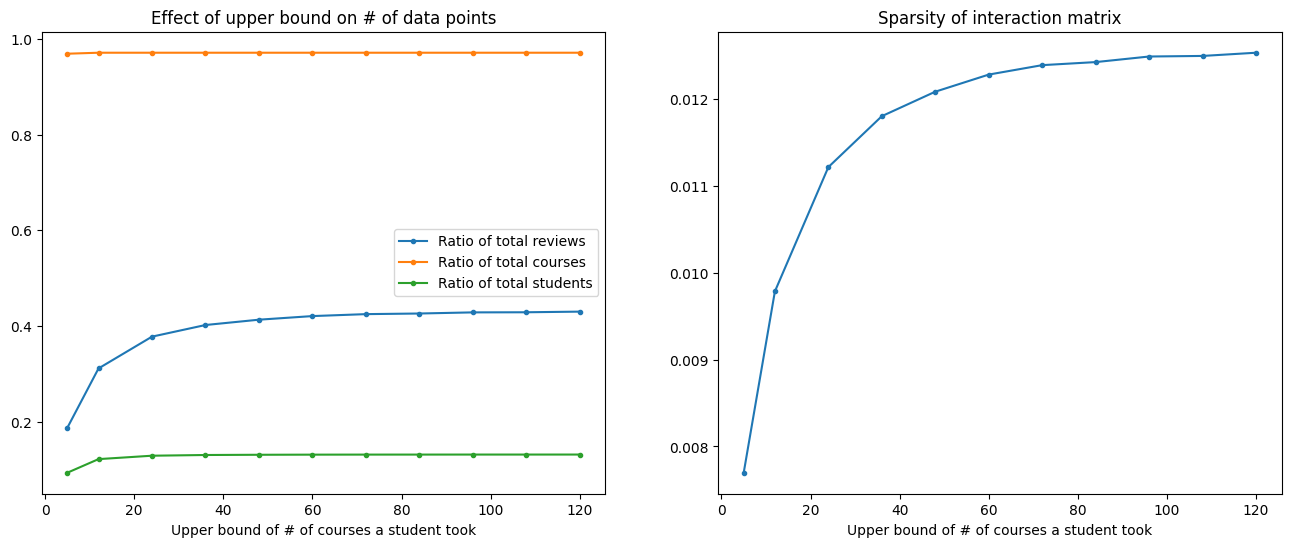

In [29]:
x = np.array([5] + [int(12 * i) for i in range(1, 11)])
results = np.array([sparsity(3, i) for i in x])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(x, results[:, 0], label='Ratio of total reviews', marker='.')
axs[0].plot(x, results[:, 1], label='Ratio of total courses', marker='.')
axs[0].plot(x, results[:, 2], label='Ratio of total students', marker='.')
axs[0].legend()
axs[0].set_xlabel('Upper bound of # of courses a student took')
axs[0].set_title('Effect of upper bound on # of data points')

axs[1].plot(x, results[:, 3], label='Sparsity', marker='.')
axs[1].set_xlabel('Upper bound of # of courses a student took')
axs[1].set_title('Sparsity of interaction matrix')

The purpose of the lower bound is so that we have a better understanding of each users’ behaviour for training and evaluation.

The lower bound has a larger effect on sparsity.

### 1.3 The Long Tail of Courses

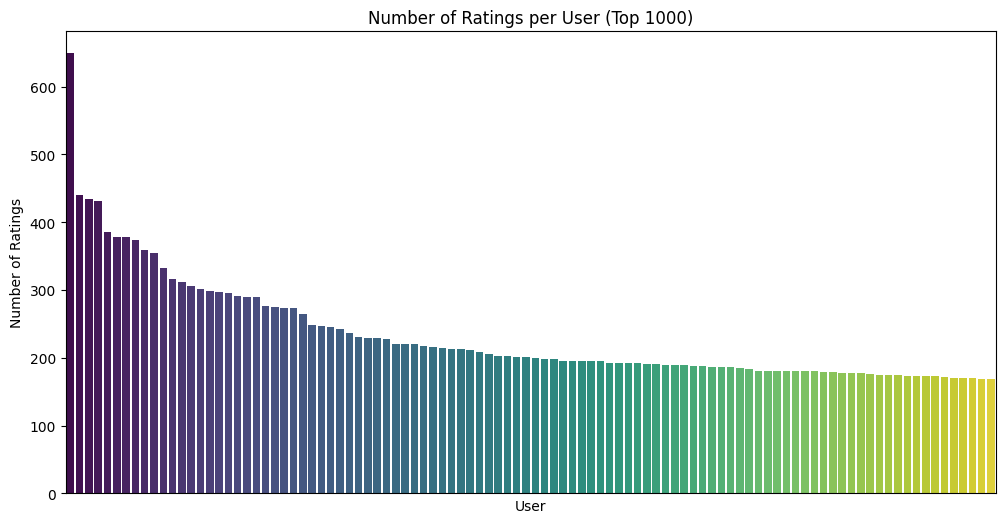

In [30]:
# Remove user "Deleted A"
df_ratings = df_ratings[df_ratings['reviewers'] != 'By Deleted A']

# The same but for users
user_rating_counts = df_ratings['reviewers'].value_counts().reset_index()
user_rating_counts.columns = ['user_id', 'rating_count']

# Sort the items by the number of ratings
user_rating_counts = user_rating_counts.sort_values('rating_count', ascending=False)

# Now, we create a line chart
plt.figure(figsize=(12, 6))
# plt.plot(user_rating_counts.index, user_rating_counts.values, marker='o', linestyle='-', color='blue')
top_n = 100
sns.barplot(x=np.arange(len(user_rating_counts.head(top_n))), y='rating_count', data=user_rating_counts.head(top_n), palette='viridis')

# Graph into bins of 100
# sns.histplot(data=user_rating_counts, x='rating_count', bins=10, kde=False)

plt.title('Number of Ratings per User (Top 1000)')
plt.xlabel('User')
plt.ylabel('Number of Ratings')
plt.xticks([])
plt.show()

A small number of courses have a very high number of ratings, indicating their popularity. For example, the first course is Python with over 600 ratings but subsequent courses have much fewer ratings. This is a common phenomenon in many recommender systems.

This presents an opportunity to personalise recommendations for users.

Even though these courses have fewer ratings, they might be highly relevant to certain users.

In the future, the model’s exposure of this long tail can be evaluated.

### 1.4 User rating distribution


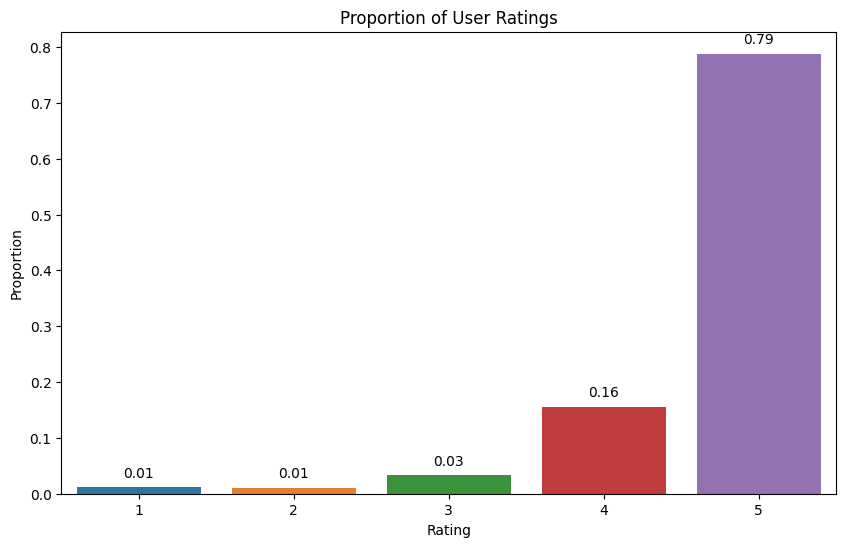

In [31]:
rating_proportions = df_ratings['rating'].value_counts(normalize=True)

# Create a bar plot for the rating proportions
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=rating_proportions.index, y=rating_proportions.values, order=range(1, 6))
plt.title('Proportion of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Proportion')

# Display the proportion on the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

Distribution of ratings is skewed towards 5 stars.

This could point to a positivity bias in the user feedback.

It might also suggest that users who are dissatisfied may choose not to leave a rating at all.

This may be a reflection of the current Coursera recommender and review system.

Our collaborative filtering models may overstate the importance of high ratings regardless of their actual quality or relevance to the user.

### 1.5 Random and Most-popular Baseline

For a sanity check, we include 2 baseline trivial methods: recommending random courses, and recommending only the most popular courses.

In [8]:
mostpopularcourses = dataset.rating_set.groupby('course_id').agg({'reviews': 'count', 'rating': 'mean'}).sort_values(by='reviews', ascending=False)

def random_courses(prev_courses, k):
    return dataset.course_set[~dataset.course_set.index.isin(prev_courses)].sample(k).index.values

def most_popular_courses(prev_courses, k):
    return mostpopularcourses[~mostpopularcourses.index.isin(prev_courses)].head(k).index.values

In [9]:
hr5 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 5)
hr10 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 10)
prec5 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 5)
prec10 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 10)
f1score5 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 5)
f1score10 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, random_courses, 10)

print("* Random *")
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hr5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hr10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

100%|█████████████████████████████████████████████████████████████████████████████| 7680/7680 [00:03<00:00, 1978.12it/s]

* Random *
    | Hit rate | Precision | F1 Score
@5  | 0.022    | 0.004     | 0.004   
@10 | 0.043    | 0.004     | 0.007   


In [11]:
hr5 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 5)
hr10 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 10)
prec5 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 5)
prec10 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 10)
f1score5 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 5)
f1score10 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, most_popular_courses, 10)

print("* Most Popular *")
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hr5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hr10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

100%|█████████████████████████████████████████████████████████████████████████████| 7680/7680 [00:01<00:00, 4535.82it/s]

* Most Popular *
    | Hit rate | Precision | F1 Score
@5  | 0.198    | 0.045     | 0.056   
@10 | 0.307    | 0.039     | 0.058   


## 2. Content-Based Recommendation

**Core Idea**

The main idea behind Content-Based Recommendation is that people will prefer similar courses. For example, if you've taken a python course, then a you might prefer another course that also uses python. 

**Problems**

This approach might cause a lack of serendipity and diversity as the recommended course might be too similar to the user profile and/or the other courses recommended.

**Process**
- Pre-processing
    - lower
    - Removal of special characters and stopwords
    - Lemming
- Checking for similarity
- Sort courses based on similarity and select top-k


### 1.1 Hyperparameter tuning

Performing a gridsearch to check for the best parameters

In [56]:
from coursemate.model import ContentBasedModel
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
model = ContentBasedModel(course_set=dataset.course_set)

# Parameters
features_list = [50,100,500,1000,5000,10000,50000,100000,500000]
vectors = [TfidfVectorizer, CountVectorizer]
categories = [['skills'], ['skills','description']]
n_users = 500

# Gridsearch
results = model.ContentBasedModel_gridsearch(df_test_X,df_test_y,vectors,n_users,features_list,categories,[5])


Best Configuration:
Vectorizer: TfidfVectorizer
n_features: 5000
Categories: ['skills', 'description']
Hitrate: 0.208


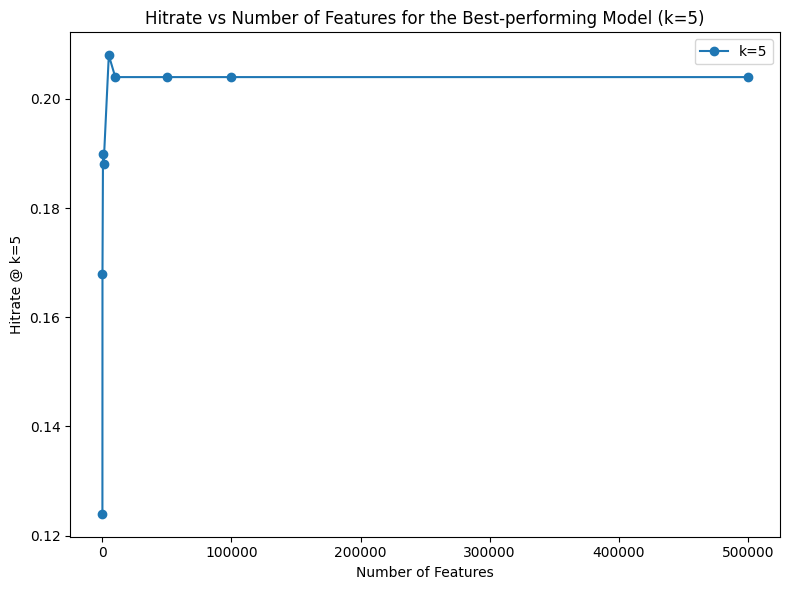

In [111]:
unique_reviewers_y = df_test_y['reviewers'].unique()

def find_best_config(results):
    best_config = None
    max_hitrate = 0.0

    for result in results:
        total_hits = sum(result['hits'].values())
        total_tests = len(result['hits']) * len(unique_reviewers_y)
        hitrate = total_hits / total_tests

        if hitrate > max_hitrate:
            max_hitrate = hitrate
            best_config = result

    return best_config

best_config = find_best_config(results)


# Print the best configuration
if best_config is not None:
    print("Best Configuration:")
    print(f"Vectorizer: {best_config['Vectorizer']}")
    print(f"n_features: {best_config['n_features']}")
    print(f"Categories: {best_config['categories']}")
    print(f"Hitrate: {best_config['hits'][k] / n_users}")
else:
    print("No best configuration found.")


def plot_hitrate_vs_n_features(best_config, k_value):
    plt.figure(figsize=(8, 6))

    vectorizer_name = str(best_config['Vectorizer']).split('.')[-1].replace("'>", "")
    categories = best_config['categories']
    features = []
    hitrates = []
    for i in results:
        if i['Vectorizer'] == vectorizer_name and i['categories'] == categories:
            hitrates.append(i['hits'][k_value]/ n_users)
            features.append(i['n_features'] )

    plt.plot(features,hitrates, label=f'k={k_value}', marker='o')

    plt.xlabel('Number of Features')
    plt.ylabel(f'Hitrate @ k={k_value}')
    plt.title(f'Hitrate vs Number of Features for the Best-performing Model (k={k_value})')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_hitrate_vs_n_features(best_config, 5)

### 1.2 Preprocessing and fitting the vectors

In [117]:
from coursemate.model import ContentBasedModel
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer
model = ContentBasedModel(course_set=dataset.course_set)

model.preprocess()
model.fit(Vectorizer=TfidfVectorizer, n_features=5000, categories=['skills','description'])

### 1.3 Recommendation

In [119]:
unique_reviewers_X = df_test_X['reviewers'].unique()
unique_reviewers_y = df_test_y['reviewers'].unique()

k_values = [5, 10]
statistics = {k: {'true_positives': 0, 'false_positives': 0, 'false_negatives': 0} for k in k_values}
hits = {k: 0 for k in k_values}
count = 0

for user in unique_reviewers_X:
    if user in unique_reviewers_y:
        count += 1
        user_profile = tuple(df_test_X[df_test_X['reviewers'] == user]['course_id'])
        target = df_test_y[df_test_y['reviewers'] == user]['course_id']

        recommendations = model.recommend(user_profile,None)
        recommendation_ids = [recommendation[0] for recommendation in recommendations]
        

        # Statistics gathering 
        for k in k_values:
            statistics[k]['true_positives'] += len(set(target) & set(recommendation_ids[:k]))
            statistics[k]['false_positives'] += len(set(recommendation_ids[:k]) - set(target))
            statistics[k]['false_negatives'] += len(set(target) - set(recommendation_ids[:k]))
            if len(set(target) & set(recommendation_ids[:k])) > 0:
                hits[k] += 1

# Metric calculation
for k in k_values:
    precision = statistics[k]['true_positives'] / (statistics[k]['true_positives'] + statistics[k]['false_positives']) if (statistics[k]['true_positives'] + statistics[k]['false_positives']) > 0 else 0
    recall = statistics[k]['true_positives'] / (statistics[k]['true_positives'] + statistics[k]['false_negatives']) if (statistics[k]['true_positives'] + statistics[k]['false_negatives']) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"For k={k}:")
    print("Precision:", precision)
    print("F1 Score:", f1_score)
    print("Hitrate", hits[k] / count)


For k=5:
Precision: 0.04513020833333333
F1 Score: 0.0638117681714412
Hitrate 0.20481770833333332
For k=10:
Precision: 0.032317708333333334
F1 Score: 0.05353984209845118
Hitrate 0.2825520833333333


## 3. Collaborative Filtering Recommendation

Collaborative Filtering (CF) is based on the assumption that users who agreed in the past will agree in the future about certain preferences. It utilises the ratings and preferences of many different users to make recommendations to similar users.


### 3.1 User-based Collaborative Filtering

**Core idea**

User-based CF recommends courses based on the preferences of similar users. It identifies users with similar tastes and preferences to the target user and suggests courses that these similar users have liked.

**Problems**

As the user base grows, the computation becomes increasingly expensive. This is because the system has to calculate the similarity between the target user and every other user in the system, thus making scalability an issue.

Also, the system might not work effectively if users have rated only a few courses (the cold start). This is because there might not be enough overlap of preferences between users to make effective recommendations.

**Process**

- A user-course matrix is created, and similarities between users are calculated, using their cosine similarity* score.
- For a given user, the system finds other similar users and generates recommendations based on the courses liked or highly rated by these similar users.

*Other similarity metrics were also considered, such as Pearson correlation and Euclidean distance. However, cosine similarity was chosen as it is more robust to sparse data and gave better results when tested.


In [46]:
from coursemate.model import UserBasedCF

# Instantiate the UserBasedCF model
user_based_cf_model = UserBasedCF()

all_train = pd.concat([df_train_X, df_train_y])

# fit with both training X and training y
user_based_cf_model.fit(all_train)

In [47]:
# Get recommendations for a particular user
user_id = 'By Kelvin k'
recommendations = user_based_cf_model.recommend(user_id, k=5)

recommendations

['aws-fundamentals-going-cloud-native',
 'information-security-data',
 'sql-for-data-science',
 'python-basics',
 'intro-sql']

In [40]:
def calculate_hit_rate(model, test_X, test_y, k=5):
    hit_count = 0
    total = 0

    for user_id in tqdm(dataset.test_students):
        user_history = test_X[test_X['reviewers'] == user_id]['course_id'].values
        actual_next_courses = test_y[test_y['reviewers'] == user_id]['course_id'].values
        
        if len(actual_next_courses) == 0:
            continue

        recommended_courses = model.recommend(user_history, k=k)

        hits = any(course in recommended_courses for course in actual_next_courses)
        hit_count += 1 if hits else 0
        total += 1

    # Calculate overall hit rate
    return hit_count / total

In [11]:
calculate_hit_rate(user_based_cf_model, df_test_X, df_test_y, k=10)

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [02:32<00:00, 50.45it/s]


0.49296875

In [12]:
calculate_hit_rate(user_based_cf_model, df_test_X, df_test_y, k=5)

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [02:18<00:00, 55.35it/s]


0.38372395833333334

### 3.2 Item-based Collaborative Filtering

**Core idea**

Item-based CF makes recommendations by finding courses similar to those that the user has already liked or rated highly. This approach assumes that if a user likes an course, they will also like similar courses.

**Problems**

Constantly recommending courses similar to those already liked can lead to a lack of diversity in recommendations.

New courses without any ratings might be neglected, as there is no way to calculate their similarity to other courses.

**Process**

- An course-course similarity matrix is built using the ratings data.
- Similarity scores between courses are computed, often using cosine similarity.
- For a target user, the system recommends courses similar to those they have rated highly.

In [41]:
from coursemate.model import ItemBasedCF

item_based_cf_model = ItemBasedCF(dataset.course_set)

all_train = pd.concat([df_train_X, df_train_y])

# Fit with both training X and training y
item_based_cf_model.fit(all_train)

In [42]:
# Use the model to get recommendations for a test user
user_previous_courses = tuple(dataset.train_ratings[dataset.train_ratings['reviewers'] == 'By Kelvin k']['course_id'])
recommendations = item_based_cf_model.recommend(user_previous_courses, k=5)

recommendations

['cybersecurity-roles-processes-operating-system-security',
 'python',
 'python-functions-files-dictionaries',
 'python-data',
 'technical-support-fundamentals']

#### Evaluation

In [43]:
def calculate_hit_rate(model, test_X, test_y, k=5):
    hit_count = 0
    total = 0

    for user_id in tqdm(dataset.test_students):
        user_history = test_X[test_X['reviewers'] == user_id]['course_id'].values
        actual_next_courses = test_y[test_y['reviewers'] == user_id]['course_id'].values
        
        if len(actual_next_courses) == 0:
            continue

        recommended_courses = model.recommend(user_history, k=k)

        hits = any(course in recommended_courses for course in actual_next_courses)
        hit_count += 1 if hits else 0
        total += 1

    # Calculate overall hit rate
    return hit_count / total


def calculate_precision(model, test_X, test_y, k=5):
    true_positives = 0
    total_recommendations = 0

    for user_id in tqdm(dataset.test_students):
        user_history = test_X[test_X['reviewers'] == user_id]['course_id'].values
        actual_next_courses = test_y[test_y['reviewers'] == user_id]['course_id'].values
        
        if len(actual_next_courses) == 0:
            continue

        recommended_courses = model.recommend(user_history, k=k)
        total_recommendations += len(recommended_courses)
        
        # Count the number of true positives
        true_positives += sum(course in actual_next_courses for course in recommended_courses)

    # Calculate precision
    if total_recommendations == 0:
        return 0
    return true_positives / total_recommendations

def calculate_recall_precision(model, test_X, test_y, k=5):
    true_positives = 0
    total_recommendations = 0
    total_relevant = 0

    for user_id in tqdm(dataset.test_students):
        user_history = test_X[test_X['reviewers'] == user_id]['course_id'].values
        actual_next_courses = test_y[test_y['reviewers'] == user_id]['course_id'].values

        total_relevant += len(actual_next_courses)
        if len(actual_next_courses) == 0:
            continue

        recommended_courses = model.recommend(user_history, k=k)
        total_recommendations += len(recommended_courses)

        true_positives += sum(course in actual_next_courses for course in recommended_courses)

    precision = true_positives / total_recommendations if total_recommendations else 0
    recall = true_positives / total_relevant if total_relevant else 0
    return recall, precision

def calculate_f1_score(recall, precision):
    if recall + precision == 0:
        return 0
    return 2 * (recall * precision) / (recall + precision)

In [44]:
hit10 = calculate_hit_rate(item_based_cf_model, df_test_X, df_test_y, k=10)
hit5 = calculate_hit_rate(item_based_cf_model, df_test_X, df_test_y, k=5)
prec10 = calculate_precision(item_based_cf_model, df_test_X, df_test_y, k=10)
prec5 = calculate_precision(item_based_cf_model, df_test_X, df_test_y, k=5)
recall10, prec10 = calculate_recall_precision(item_based_cf_model, df_test_X, df_test_y, k=10)
recall5, prec5 = calculate_recall_precision(item_based_cf_model, df_test_X, df_test_y, k=5)
f1score10 = calculate_f1_score(recall10, prec10)
f1score5 = calculate_f1_score(recall5, prec5)

100%|██████████| 7680/7680 [03:42<00:00, 34.54it/s]


In [45]:
print("* Item-based Collaborative Filtering *")
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hit5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hit10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

* Item-based Collaborative Filtering *
    | Hit rate | Precision | F1 Score
@5  | 0.384    | 0.091     | 0.128   
@10 | 0.493    | 0.063     | 0.104   


#### Results

After implementing both user-based and item-based collaborative filtering, it was found that item-based CF generally yielded better results. This could be attributed to its higher stability, as well as its ability to effectively handle larger datasets with more items than users.

However, it's important to consider the potential lack of diversity in recommendations and the challenge of introducing new items. For this reason, we have investigated using a sequence-aware model in a hybrid approach to address these issues and improve the overall performance of the recommender system as seen in the next sections.

## 4. Sequential/Knowledge-Based Recommendation

**Core idea**

The core idea of the method is that people would take courses in a sequential manner, such as going from introductory to intermediate to advanced. Some courses in Coursera are even part of a curriculum. Thus, we can recommend courses based on a user’s previously taken courses.

**Training**

For each user who has taken n courses, we can generate n-1 data (e.g. given the first k courses, predict the next course). To match with the other methods during evaluation, we predict any of the next courses.

**Problems**

As previously discovered in EDA, most users only take a few courses (1-3), yielding a skewed distribution of primarily short sequences. Moreover, this method cannot solve the cold-start problem as a previous course is required. Finally, as with most recommendation tasks, the data itself is sparse in interactions.

**Methods**

* A baseline was first made by simply recommending the most popular "next courses" given a user's taken courses. When considering raw count, this biases towards more popular courses. Doing so yielded a 26% hit rate on all subsequences (of which the evaluation set is a subset of).
* When considering probability, as with a Markov chain, this biases towards niche courses where all users take the same next course, as the low count makes it easier to reach high probabilities. This unfortunately performed worse, with a 19% hit rate.
* The last method tested was a sequential rule mining method to determine ordered associations from frequent item subsequences. Recommendations are then chosen from rules with a high confidence. This yielded a 27% hit rate. This method, while simple and explainable, is also computationally expensive.

**Process**

* For the sake of speeding up computation, we go over all subsequences and note down all combinations, instead of generating combinations and counting their occurrences in the subsequences.
* We limit ourselves to 1, 2, and 3-course subsequences. Then we generate 1 and 2-course antecedents from the 2 and 3-course subsequences, like so:
    * (a → b → c) becomes (a, b) → (c)
* For each rule, we calculate confidence and lift, and use either as a score for ranking recommendations. We found confidence to perform the best.
* To recommend items, we generate all subsequences from a user’s sequence of courses, find association rules with antecedents that match that of the subsequence, then finally get consequent courses with highest confidence

In [12]:
from coursemate.model import AssociationMiningModel

# support cutoff determined empirically, testing the 90th and 99th percentile
model = AssociationMiningModel(cutoff=3, course_set=dataset.course_set)
df_seq = model.get_sequences_data(train_Xseq, train_yseq)
model.fit(df_seq)

100%|██████████████████████████████████████████████████████████████████████████| 23039/23039 [00:02<00:00, 10044.86it/s]


1-subsequences: 468
2-subsequences: 90472
3-subsequences: 1835231
(1926171, 2)


In [13]:
hr5 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
hr10 = calculate_hit_rate_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
prec5 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
prec10 = calculate_precision_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)
f1score5 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 5)
f1score10 = calculate_f1score_from_next_course_sequences(test_Xseq, test_yseq, model.recommend, 10)

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [02:17<00:00, 56.03it/s]


In [14]:
print("* Sequential *")
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hr5:.3f}    | {prec5:.3f}     | {f1score5:.3f}   ")
print(f"@10 | {hr10:.3f}    | {prec10:.3f}     | {f1score10:.3f}   ")

* Sequential *
    | Hit rate | Precision | F1 Score
@5  | 0.374    | 0.086     | 0.118   
@10 | 0.490    | 0.062     | 0.097   


**Results**

The sequential method performs really similarly to the collaborative filtering method, possibly because there is a correlation between similar users doing the same courses, and the order at which they take them. It's also interesting to note that this method, unlike CF, doesn't make use of the actual ratings.

## 5. Hybrid

**Core idea**

By combining all 3 methods, we can hopefully balance the personal relevance of content-based recommendations with the social proof in collaborative filtering, while also considering the temporal user interactions through sequential-based recommendations. We can suggest courses that not only match a user's past behavior and preferences but also introduce new and relevant topics that similar users have liked. Finally, we can help address the cold start problem by first using content based using a user profile.

**Process**

* Scores from each of the 3 methods (Content similarity, Item cosine similarity, and Rule confidence) are scaled between 0 to 1, then they are aggregated (max-value aggregation)
* The choice of scaling and aggregation can greatly affect the results

In [15]:
# loading the scores

scores_content = pd.read_csv('/mnt/d/School/COMP9727/content-based-recommender-full.csv') \
                   .melt(id_vars='Unnamed: 0') \
                   .rename(columns={'Unnamed: 0': 'user', 'variable': 'course', 'value': 'content_similarity'})
# scores_user_cf = pd.read_pickle('user_based_cf_scores.pkl')
# scores_user_cf.columns = ['user', 'course', 'user_based_rating']
scores_item_cf = pd.read_csv('/mnt/d/School/COMP9727/item_based_collab_results_commas.csv') \
                   .iloc[:, 1:] \
                   .rename(columns={'user_id': 'user', 'course_id': 'course', 'predicted_rating': 'item_based_similarity'})
scores_sequential = pd.read_pickle('sequential_rm_scores.pkl')

In [17]:
print(f"Content-based predictions: {scores_content.user.nunique()} users, {scores_content.course.nunique()} courses")
print(f"Item-based CF predictions: {scores_item_cf.user.nunique()} users, {scores_item_cf.course.nunique()} courses")
print(f"Sequential predictions: {scores_sequential.user.nunique()} users, {scores_sequential.course.nunique()} courses")

Content-based predictions: 7680 users, 468 courses
Item-based CF predictions: 7680 users, 468 courses
Sequential predictions: 7680 users, 446 courses


In [18]:
# remove suspiciously high content similarities
scores_content_filtered = scores_content[scores_content['content_similarity'] < 1]

# standardize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scores_content_filtered['content_similarity_scaled'] = scaler.fit_transform(scores_content_filtered['content_similarity'].values.reshape(-1, 1))[:, 0]
scores_item_cf['item_based_rating_scaled'] = scaler.fit_transform(scores_item_cf['item_based_similarity'].values.reshape(-1, 1))[:, 0]
# scores_sequential['confidence_scaled'] = scaler.fit_transform(np.log(scores_sequential['confidence']).values.reshape(-1, 1))[:, 0]
scores_sequential['confidence_scaled'] = scaler.fit_transform(scores_sequential['confidence'].values.reshape(-1, 1))[:, 0]

/tmp/ipykernel_2152/1415534881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_content_filtered['content_similarity_scaled'] = scaler.fit_transform(scores_content_filtered['content_similarity'].values.reshape(-1, 1))[:, 0]


Text(0.5, 1.0, 'Confidence of Sequential Rule (scaled)')

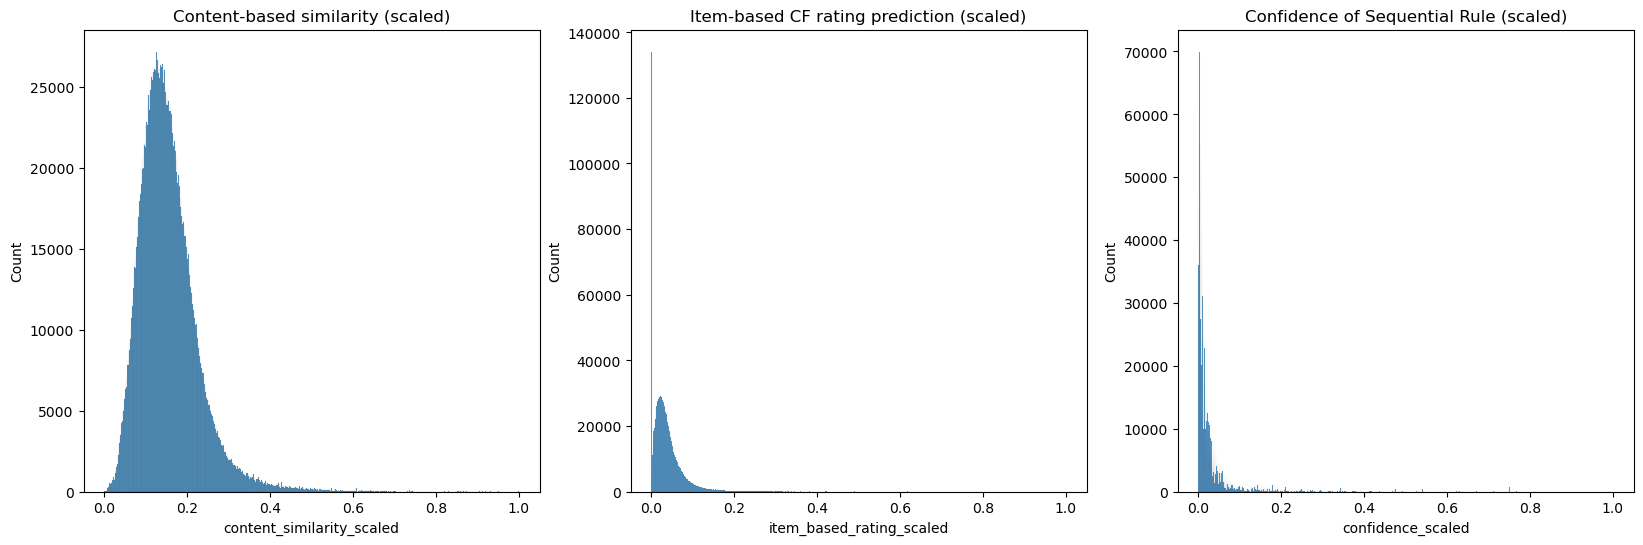

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(scores_content_filtered['content_similarity_scaled'], ax=axs[0])
axs[0].set_title('Content-based similarity (scaled)')
sns.histplot(scores_item_cf['item_based_rating_scaled'], ax=axs[1])
axs[1].set_title('Item-based CF rating prediction (scaled)')
sns.histplot(scores_sequential['confidence_scaled'], ax=axs[2])
axs[2].set_title('Confidence of Sequential Rule (scaled)')

In [20]:
df_hybrid = scores_content_filtered[['user', 'course', 'content_similarity_scaled']].merge(
    scores_item_cf[['user', 'course', 'item_based_rating_scaled']], how='left', on=['user', 'course']
).merge(
    scores_sequential[['user', 'course', 'confidence_scaled']], how='left', on=['user', 'course']
).fillna(0)

In [21]:
df_hybrid['hybrid_avg_score'] = (df_hybrid['content_similarity_scaled'] + df_hybrid['item_based_rating_scaled'] + df_hybrid['confidence_scaled']) / 3
df_hybrid['hybrid_max_score'] = df_hybrid[['content_similarity_scaled', 'item_based_rating_scaled', 'confidence_scaled']].max(axis=1)
df_hybrid = df_hybrid.sort_values(by='hybrid_max_score', ascending=False)

In [22]:
df_hybrid.head()

,user,course,content_similarity_scaled,item_based_rating_scaled,confidence_scaled,hybrid_avg_score,hybrid_max_score
409482,By Xiaolong L,machine-learning-projects,0.537694,1.000000,0.593085,0.710260,1.0
407558,By Samuel N,machine-learning-projects,0.279494,0.363522,1.000000,0.547672,1.0
407658,By Jorge B P,machine-learning-projects,0.376709,0.418285,1.000000,0.598331,1.0
409885,By Rajeev R,machine-learning-projects,0.271280,0.231034,1.000000,0.500771,1.0
404114,By Shikhar R,machine-learning-projects,0.286167,0.456499,1.000000,0.580889,1.0


In [23]:
users = 0
hits5 = 0
precs5 = 0
f1scores5 = 0
hits10 = 0
precs10 = 0
f1scores10 = 0

for (user, prev_courses), next_course in tqdm(zip(test_Xseq, test_yseq), total=len(test_Xseq)):
    users += 1
    _df = df_hybrid[df_hybrid.user == user].head(10)
    pred_courses5 = set(_df.head(5)['course'].values)
    pred_courses10 = set(_df['course'].values)
    next_courses_set = set(next_course)
    precision5 = (len(pred_courses5 & next_courses_set) / max(len(pred_courses5), 1))
    recall5 = (len(pred_courses5 & next_courses_set) / max(len(next_course), 1))
    precision10 = (len(pred_courses10 & next_courses_set) / max(len(pred_courses10), 1))
    recall10 = (len(pred_courses10 & next_courses_set) / max(len(next_course), 1))

    precs5 += precision5
    if precision5 + recall5 > 0:
        f1scores5 += (2 * (precision5 * recall5) / (precision5 + recall5))
    if precision5 > 0:
        hits5 += 1
        
    precs10 += precision10
    if precision10 + recall10 > 0:
        f1scores10 += (2 * (precision10 * recall10) / (precision10 + recall10))
    if precision10 > 0:
        hits10 += 1

100%|███████████████████████████████████████████████████████████████████████████████| 7680/7680 [39:07<00:00,  3.27it/s]


In [24]:
print(f"    | Hit rate | Precision | F1 Score")
print(f"@5  | {hits5 / users:.3f}    | {precs5 / users:.3f}     | {f1scores5 / users:.3f}   ")
print(f"@10 | {hits10 / users:.3f}    | {precs10 / users:.3f}     | {f1scores10 / users:.3f}   ")

    | Hit rate | Precision | F1 Score
@5  | 0.272    | 0.061     | 0.085   
@10 | 0.358    | 0.042     | 0.068   


**Results**

The hybrid method seems to perform better than content-based but worse than the other 2 methods. It is likely that the content-based score affects the aggregate score. 